# **OHIOT1DM DATA PROCESSING**   
- **Without feature enhancement**  
 
- **2:1:2 hypo:eu:hyper sampling ratio**  

# **CONTENTS**

[1. Requirements & Encironment](##1.-Requirements-&-Environment)  
[2. Read n OHIO-T1DM Data](##2.-Read-n-OHIO-T1DM-Data)  
[3. Initial Data Processing](##3.-OHIO-T1DM-Data-Initial-Processing)  
[4. OHIO T1DM Data Processing - No Undersampling](##4.-OHIO-T1DM-Data-Processing---No-Undersampling)  
[5. OHIO T1DM Data Processing - Hypo Oversamplin and  Eu/Hyper Undersampling](##5.-OHIO-T1DM-Data-Processing---Hypo-Oversampling-and-Eu/Hyper-Undersampling)  
[6. OHIO T1DM Validation Data Processing](##6.-OHIO-T1DM-Validation-Data-Processing)  
[7, OHIO T1DM Validation Data Processing with Undersampling](##7.-OHIO-T1DM-Validation-Data-Processing-with-Undersampling)  
[8. OHIO T1DM Test Data Processing](##8.-OHIO-T1DM-Test-Data-Processing)  



## **1. Requirements & Environment**

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sys
import random


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data_processing_modules import *
from data_processing_parameters import *



In [74]:
current_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, "../../"))

In [75]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


In [76]:
# saved file file paths

ohio_training_directory_no_undersampling = '../processed_data/ohio/training/no_undersampling'
os.makedirs(ohio_training_directory_no_undersampling, exist_ok=True)

ohio_training_directory_undersampling = '../processed_data/ohio/training/over_and_under_sampling'
os.makedirs(ohio_training_directory_undersampling, exist_ok=True)

ohio_validation_directory = '../processed_data/ohio/validation'
os.makedirs(ohio_validation_directory, exist_ok=True)

ohio_test_directory = '../processed_data/ohio/testing'
os.makedirs(ohio_test_directory, exist_ok=True)

[Back to Table of Contents](#CONTENTS)

## **2. Read in OHIO-T1DM Data**

In [77]:
ohio_training_data = get_ohio_data('training', 'Train')

In [78]:
print(ohio_training_data.keys())

dict_keys([584, 575, 563, 559, 540, 596, 588, 570, 591, 567, 552, 544])


In [79]:
ohio_test_data = get_ohio_data('test', 'Test')

In [80]:
ohio_test_data.keys()

dict_keys([552, 540, 559, 544, 588, 570, 563, 596, 591, 584, 567, 575])

In [81]:
print(ohio_training_data.keys() == ohio_test_data.keys())

True


[Back to Table of Contents](#CONTENTS)

Confirms that data for each patient ID is present in both the training and testing datasets.

## **3. OHIO-T1DM Data Initial Processing**

In [82]:
for ptid, df in ohio_training_data.items():
    print(f"Patient ID: {ptid}, Number of Glucose Measurements: {len(df)}")

Patient ID: 584, Number of Glucose Measurements: 12150
Patient ID: 575, Number of Glucose Measurements: 11866
Patient ID: 563, Number of Glucose Measurements: 12124
Patient ID: 559, Number of Glucose Measurements: 10796
Patient ID: 540, Number of Glucose Measurements: 11947
Patient ID: 596, Number of Glucose Measurements: 10877
Patient ID: 588, Number of Glucose Measurements: 12640
Patient ID: 570, Number of Glucose Measurements: 10982
Patient ID: 591, Number of Glucose Measurements: 10847
Patient ID: 567, Number of Glucose Measurements: 10858
Patient ID: 552, Number of Glucose Measurements: 9080
Patient ID: 544, Number of Glucose Measurements: 10623


In [83]:
ohio_training_dict = {}
ohio_validation_dict = {}

for ptid, df in ohio_training_data.items():
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    ohio_training_dict[ptid] = train
    ohio_validation_dict[ptid] = test

[Back to Table of Contents](#CONTENTS)

## **4. OHIO T1DM Data Processing - No Undersampling**

In [84]:
for ptid, df in ohio_training_dict.items():
    df = df.copy()
    df['real_value_flag'] = 1
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()

    # Identify rows where TimeDiff is around 600 seconds (10 min)
    mask = (df['TimeDiff'] > 595) & (df['TimeDiff'] < 605)
    insert_rows = df[mask].copy()

    if not insert_rows.empty:
        # Modify new rows: set `real_value_flag = 0`, shift `DateTime`, and set `GlucoseValue = NaN`
        insert_rows['real_value_flag'] = 0
        insert_rows['timestamp'] -= pd.to_timedelta(5, unit='m')
        insert_rows['GlucoseValue'] = np.nan

        # Append new rows to the dataframe and sort
        df = pd.concat([df, insert_rows]).sort_values(by='timestamp').reset_index(drop=True)

    # Convert 'value' column to numeric before interpolation
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['GlucoseValue'] = df['value'].interpolate(method='linear')

    df['Hour'] = df['timestamp'].dt.hour
    df['Minute'] = df['timestamp'].dt.minute
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()
    df['TimeDiffFlag'] = df['TimeDiff'].apply(lambda x: 0 if x < 295 or x > 305 else 1)
    df['RollingTimeDiffFlag'] = df['TimeDiffFlag'].rolling(window=96).sum()

    # Drop first 96 rows due to NaN values
    # df = df.iloc[95:].reset_index(drop=True)

    # drop columns
    df = df.drop(columns=['timestamp', 'value', 'TimeDiff', 'TimeDiffFlag', 'real_value_flag'])

    ohio_training_dict[ptid] = df

In [85]:
# Replace-BG normalisation metrics

normalisation_mean = 152.91051040286524

normalisation_std = 70.27050122812615

In [86]:
for ptid, df in ohio_training_dict.items():
    df['GlucoseValue'] = (df['GlucoseValue'] - normalisation_mean) / normalisation_std

In [87]:
ptid_training_slice_dict = {}


for ptid, df in ohio_training_dict.items():
    rolling_flag_array = df["RollingTimeDiffFlag"].to_numpy()  # Convert to NumPy array for fast indexing
    num_rows = len(df)
    starting_index = 0

    slice_list = []

    while starting_index + slice_size <= num_rows:
        if rolling_flag_array[starting_index + slice_size - 1] == slice_size:  # Use precomputed array
            slice_df = df.iloc[starting_index:starting_index + slice_size].copy()
            slice_df = slice_df.drop(columns='RollingTimeDiffFlag')
            slice_list.append(slice_df)
            starting_index += 1

        else:
            starting_index += 1
        
    ptid_training_slice_dict[ptid] = slice_list

In [88]:
# for ptid, slice_list in ptid_training_slice_dict.items():
#     print(ptid)
#     print(len(slice_list))
#         #pritn tail(23) of first 3 slices
#     for i in range(3):
#         display(slice_list[i].tail(23))
#     print("\n")

In [89]:
for ptid, slice_list in ptid_training_slice_dict.items():


    ptid_count = 0

    encoder_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'EncoderSlices')
    os.makedirs(encoder_dir, exist_ok=True)
    decoder_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'DecoderSlices')
    os.makedirs(decoder_dir, exist_ok=True)
    target_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'TargetSlices')
    os.makedirs(target_dir, exist_ok=True)

    for i, slice_df in enumerate(slice_list):
        # Replace all instances of 'slice' with 'slice_df'
        encoder_input = slice_df.iloc[:encoder_input_size]
        target = slice_df.iloc[encoder_input_size:]['GlucoseValue']

        decoder_input = slice_df.iloc[-decoder_input_size:].copy().reset_index(drop=True)
        decoder_input.loc[decoder_input.index[start_token_size:], 'GlucoseValue'] = 0

        encoder_path = os.path.join(encoder_dir, f'{ptid_count}.pt')
        decoder_path = os.path.join(decoder_dir, f'{ptid_count}.pt')
        target_path = os.path.join(target_dir, f'{ptid_count}.pt')

        torch.save(torch.tensor(encoder_input.values, dtype=torch.float32), encoder_path)
        torch.save(torch.tensor(decoder_input.values, dtype=torch.float32), decoder_path)
        torch.save(torch.tensor(target.values, dtype=torch.float32), target_path)

        ptid_count += 1

In [90]:
[584, 575, 563, 559, 540, 596, 588, 570, 591, 567, 552, 544]

for ptid in ohio_training_dict.keys():


    encoder_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'EncoderSlices')
    decoder_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'DecoderSlices')
    target_dir = os.path.join(ohio_training_directory_no_undersampling, f'ohio_training_{ptid}', 'TargetSlices')

    encoder_tensor = get_first_file(encoder_dir)
    decoder_tensor = get_first_file(decoder_dir)
    target_tensor = get_first_file(target_dir)


    encoder_tensor = torch.load(encoder_tensor)
    decoder_tensor = torch.load(decoder_tensor)
    target_tensor = torch.load(target_tensor)

    encoder_df = pd.DataFrame(encoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
    decoder_df = pd.DataFrame(decoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
    target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])

    denormalised_encoder_df = encoder_df.copy()
    denormalised_decoder_df = decoder_df.copy()
    denormalised_target_df = target_df.copy()

    denormalised_encoder_df['GlucoseValue'] = (denormalised_encoder_df['GlucoseValue'] * normalisation_std) + normalisation_mean
    denormalised_decoder_df['GlucoseValue'] = (denormalised_decoder_df['GlucoseValue'] * normalisation_std) + normalisation_mean
    denormalised_target_df['GlucoseValue'] = (denormalised_target_df['GlucoseValue'] * normalisation_std) + normalisation_mean
    encoder_df = denormalised_encoder_df
    decoder_df = denormalised_decoder_df
    target_df = denormalised_target_df

    print(f"\n Patient ID: {ptid}")
    print(f"\n Encoder Shape: {encoder_df.shape}")
    display(encoder_df.tail())
    print(f"\n Decoder Shape: {decoder_df.shape}")
    display(decoder_df.tail())
    print(f"\n Target Shape: {target_df.shape}")
    display(target_df.tail(23))
    print("\n\n")


 Patient ID: 584

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,184.0,19.0,47.0
68,182.0,19.0,52.0
69,180.0,19.0,57.0
70,178.0,20.0,2.0
71,176.0,20.0,7.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,21.0,47.0
32,152.910507,21.0,52.0
33,152.910507,21.0,57.0
34,152.910507,22.0,2.0
35,152.910507,22.0,7.0



 Target Shape: (24, 1)


,GlucoseValue
1,176.0
2,177.0
3,179.0
4,180.0
5,181.0
6,183.0
7,187.0
8,191.0
9,193.0
10,197.0






 Patient ID: 575

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,57.999992,18.0,23.0
68,58.999992,18.0,28.0
69,59.999992,18.0,33.0
70,61.999992,18.0,38.0
71,64.000000,18.0,43.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,20.0,23.0
32,152.910507,20.0,28.0
33,152.910507,20.0,33.0
34,152.910507,20.0,38.0
35,152.910507,20.0,43.0



 Target Shape: (24, 1)


,GlucoseValue
1,66.000000
2,67.000000
3,69.000000
4,71.000000
5,75.000000
6,78.999992
7,87.000000
8,96.000000
9,105.000000
10,114.000000






 Patient ID: 563

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,206.0,18.0,35.0
68,213.0,18.0,40.0
69,222.0,18.0,45.0
70,235.0,18.0,50.0
71,248.0,18.0,55.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,20.0,35.0
32,152.910507,20.0,40.0
33,152.910507,20.0,45.0
34,152.910507,20.0,50.0
35,152.910507,20.0,55.0



 Target Shape: (24, 1)


,GlucoseValue
1,256.000000
2,246.000000
3,239.000000
4,227.000000
5,211.000000
6,193.000000
7,172.000000
8,152.000000
9,137.000000
10,125.000000






 Patient ID: 559

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,320.0,21.0,16.0
68,315.0,21.0,21.0
69,308.0,21.0,26.0
70,302.0,21.0,31.0
71,296.0,21.0,36.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,23.0,16.0
32,152.910507,23.0,21.0
33,152.910507,23.0,26.0
34,152.910507,23.0,31.0
35,152.910507,23.0,36.0



 Target Shape: (24, 1)


,GlucoseValue
1,270.0
2,263.0
3,256.0
4,251.0
5,247.0
6,244.0
7,240.0
8,236.0
9,232.0
10,227.0






 Patient ID: 540

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,138.0,14.0,49.0
68,140.0,14.0,54.0
69,139.0,14.0,59.0
70,133.0,15.0,4.0
71,128.0,15.0,9.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,16.0,49.0
32,152.910507,16.0,54.0
33,152.910507,16.0,59.0
34,152.910507,17.0,4.0
35,152.910507,17.0,9.0



 Target Shape: (24, 1)


,GlucoseValue
1,123.0
2,122.0
3,116.0
4,110.0
5,108.0
6,112.0
7,137.0
8,143.0
9,149.0
10,148.0






 Patient ID: 596

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,145.0,14.0,5.0
68,152.0,14.0,10.0
69,159.0,14.0,15.0
70,168.0,14.0,20.0
71,175.0,14.0,25.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,16.0,5.0
32,152.910507,16.0,10.0
33,152.910507,16.0,15.0
34,152.910507,16.0,20.0
35,152.910507,16.0,25.0



 Target Shape: (24, 1)


,GlucoseValue
1,185.0
2,184.0
3,182.0
4,182.0
5,181.0
6,179.0
7,179.0
8,179.0
9,179.0
10,178.0






 Patient ID: 588

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,131.0,17.0,46.0
68,127.0,17.0,51.0
69,123.0,17.0,56.0
70,120.0,18.0,1.0
71,117.0,18.0,6.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,19.0,46.0
32,152.910507,19.0,51.0
33,152.910507,19.0,56.0
34,152.910507,20.0,1.0
35,152.910507,20.0,6.0



 Target Shape: (24, 1)


,GlucoseValue
1,117.0
2,119.0
3,119.0
4,123.0
5,130.0
6,139.0
7,147.0
8,154.0
9,159.0
10,162.0






 Patient ID: 570

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,140.0,0.0,12.0
68,137.0,0.0,17.0
69,135.0,0.0,22.0
70,134.0,0.0,27.0
71,132.0,0.0,32.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,2.0,12.0
32,152.910507,2.0,17.0
33,152.910507,2.0,22.0
34,152.910507,2.0,27.0
35,152.910507,2.0,32.0



 Target Shape: (24, 1)


,GlucoseValue
1,145.0
2,143.0
3,137.0
4,132.0
5,128.0
6,126.0
7,123.0
8,121.0
9,120.0
10,120.0






 Patient ID: 591

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,180.0,18.0,58.0
68,187.0,19.0,3.0
69,192.0,19.0,8.0
70,185.0,19.0,13.0
71,179.0,19.0,18.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,20.0,58.0
32,152.910507,21.0,3.0
33,152.910507,21.0,8.0
34,152.910507,21.0,13.0
35,152.910507,21.0,18.0



 Target Shape: (24, 1)


,GlucoseValue
1,136.000000
2,112.000000
3,94.000000
4,81.999992
5,77.999992
6,77.000000
7,77.999992
8,79.999992
9,82.999992
10,86.000000






 Patient ID: 567

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,133.0,6.0,56.0
68,136.0,7.0,1.0
69,138.0,7.0,6.0
70,138.0,7.0,11.0
71,138.0,7.0,16.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,8.0,56.0
32,152.910507,9.0,1.0
33,152.910507,9.0,6.0
34,152.910507,9.0,11.0
35,152.910507,9.0,16.0



 Target Shape: (24, 1)


,GlucoseValue
1,144.0
2,146.0
3,150.0
4,151.0
5,153.0
6,155.0
7,158.0
8,161.0
9,162.0
10,165.0






 Patient ID: 552

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,72.000000,21.0,55.0
68,77.000000,22.0,0.0
69,79.999992,22.0,5.0
70,93.000000,22.0,10.0
71,108.000000,22.0,15.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,23.0,55.0
32,152.910507,0.0,0.0
33,152.910507,0.0,5.0
34,152.910507,0.0,10.0
35,152.910507,0.0,15.0



 Target Shape: (24, 1)


,GlucoseValue
1,129.0
2,130.0
3,130.0
4,132.0
5,140.0
6,152.0
7,157.0
8,160.0
9,160.0
10,158.0






 Patient ID: 544

 Encoder Shape: (72, 3)


,GlucoseValue,Hour,Minute
67,164.0,23.0,59.0
68,162.0,0.0,4.0
69,160.0,0.0,9.0
70,158.0,0.0,14.0
71,156.0,0.0,19.0



 Decoder Shape: (36, 3)


,GlucoseValue,Hour,Minute
31,152.910507,1.0,59.0
32,152.910507,2.0,4.0
33,152.910507,2.0,9.0
34,152.910507,2.0,14.0
35,152.910507,2.0,19.0



 Target Shape: (24, 1)


,GlucoseValue
1,152.0
2,150.0
3,148.0
4,146.0
5,145.0
6,143.0
7,141.0
8,139.0
9,136.0
10,127.0


[Back to Table of Contents](#CONTENTS)

## **5. OHIO T1DM Data Processing - Hypo OverSampling and Eu/Hyper Undersampling**


In [91]:
ptid_hypo_training_slice_dict = {}
ptid_hyper_training_slice_dict = {}
ptid_eu_training_slice_dict = {}

for ptid, df_list in ptid_training_slice_dict.items():
    hypo_list = []
    hyper_list = []
    eu_list = []

    normalised_hypo_threshold = (70 - normalisation_mean) / normalisation_std
    normalised_hyper_threshold = (180 - normalisation_mean) / normalisation_std

    threshold_count = 6

    for slice in df_list:

        target_slice = slice.iloc[-target_size:]['GlucoseValue'].values

        hypo_count = np.sum(target_slice < normalised_hypo_threshold)
        hyper_count = np.sum(target_slice > normalised_hyper_threshold)
        eu_count = target_size - hypo_count - hyper_count

        if hypo_count >= threshold_count:
            hypo_list.append(slice)
        elif hyper_count >= threshold_count:
            hyper_list.append(slice)
        else:
            eu_list.append(slice)

    
    print(f"Patient ID: {ptid}, Hypo: {len(hypo_list)}, Hyper: {len(hyper_list)}, EU: {len(eu_list)}")

    ptid_hypo_training_slice_dict[ptid] = hypo_list
    ptid_hyper_training_slice_dict[ptid] = hyper_list
    ptid_eu_training_slice_dict[ptid] = eu_list

Patient ID: 584, Hypo: 97, Hyper: 3366, EU: 2138
Patient ID: 575, Hypo: 641, Hyper: 1140, EU: 2725
Patient ID: 563, Hypo: 357, Hyper: 2411, EU: 5497
Patient ID: 559, Hypo: 270, Hyper: 2635, EU: 2584
Patient ID: 540, Hypo: 847, Hyper: 2143, EU: 4703
Patient ID: 596, Hypo: 146, Hyper: 2390, EU: 4343
Patient ID: 588, Hypo: 141, Hyper: 4332, EU: 4781
Patient ID: 570, Hypo: 190, Hyper: 4523, EU: 2711
Patient ID: 591, Hypo: 279, Hyper: 3004, EU: 3398
Patient ID: 567, Hypo: 402, Hyper: 1659, EU: 2508
Patient ID: 552, Hypo: 329, Hyper: 1313, EU: 2732
Patient ID: 544, Hypo: 189, Hyper: 3251, EU: 3571


In [92]:
for ptid, slice_list in ptid_hypo_training_slice_dict.items():
    #duplicate the hypo slices
    slice_list = slice_list + slice_list
    ptid_hypo_training_slice_dict[ptid] = slice_list
    print(f"Patient ID: {ptid}, Hypo: {len(slice_list)}")

Patient ID: 584, Hypo: 194
Patient ID: 575, Hypo: 1282
Patient ID: 563, Hypo: 714
Patient ID: 559, Hypo: 540
Patient ID: 540, Hypo: 1694
Patient ID: 596, Hypo: 292
Patient ID: 588, Hypo: 282
Patient ID: 570, Hypo: 380
Patient ID: 591, Hypo: 558
Patient ID: 567, Hypo: 804
Patient ID: 552, Hypo: 658
Patient ID: 544, Hypo: 378


In [93]:
for ptid, slice_list in ptid_hyper_training_slice_dict.items():

    target_size = len(ptid_hypo_training_slice_dict[ptid])

    hyper_dict = {idx: slice for idx, slice in enumerate(slice_list)}
    hyper_dict = undersample_dict(hyper_dict, target_size)

    ptid_hyper_training_slice_dict[ptid] = list(hyper_dict.values())

    print(f"Patient ID: {ptid}, Hyper: {len(ptid_hyper_training_slice_dict[ptid])}")

Patient ID: 584, Hyper: 194
Patient ID: 575, Hyper: 1140
Patient ID: 563, Hyper: 714
Patient ID: 559, Hyper: 540
Patient ID: 540, Hyper: 1694
Patient ID: 596, Hyper: 292
Patient ID: 588, Hyper: 282
Patient ID: 570, Hyper: 380
Patient ID: 591, Hyper: 558
Patient ID: 567, Hyper: 804
Patient ID: 552, Hyper: 658
Patient ID: 544, Hyper: 378


In [94]:
for ptid, slice_list in ptid_eu_training_slice_dict.items():

    target_size = len(ptid_hypo_training_slice_dict[ptid])

    eu_dict = {idx: slice for idx, slice in enumerate(slice_list)}
    eu_dict = undersample_dict(eu_dict, target_size)

    ptid_eu_training_slice_dict[ptid] = list(eu_dict.values())

    print(f"Patient ID: {ptid}, EU: {len(ptid_eu_training_slice_dict[ptid])}")

Patient ID: 584, EU: 194
Patient ID: 575, EU: 1282
Patient ID: 563, EU: 714
Patient ID: 559, EU: 540
Patient ID: 540, EU: 1694
Patient ID: 596, EU: 292
Patient ID: 588, EU: 282
Patient ID: 570, EU: 380
Patient ID: 591, EU: 558
Patient ID: 567, EU: 804
Patient ID: 552, EU: 658
Patient ID: 544, EU: 378


In [95]:
undersampled_training_dict = {}

for ptid, slice_list in ptid_hypo_training_slice_dict.items():
    hypo_slices = slice_list
    hyper_slices = ptid_hyper_training_slice_dict[ptid]
    eu_slices = ptid_eu_training_slice_dict[ptid]

    final_slices = hypo_slices + hyper_slices + eu_slices

    np.random.shuffle(final_slices)
    undersampled_training_dict[ptid] = final_slices

    print(f"Patient ID: {ptid}, Total Slices: {len(final_slices)}")

Patient ID: 584, Total Slices: 582
Patient ID: 575, Total Slices: 3704
Patient ID: 563, Total Slices: 2142
Patient ID: 559, Total Slices: 1620
Patient ID: 540, Total Slices: 5082
Patient ID: 596, Total Slices: 876
Patient ID: 588, Total Slices: 846
Patient ID: 570, Total Slices: 1140
Patient ID: 591, Total Slices: 1674
Patient ID: 567, Total Slices: 2412
Patient ID: 552, Total Slices: 1974
Patient ID: 544, Total Slices: 1134


In [96]:
for ptid, slice_list in undersampled_training_dict.items():
    
    ptid_count = 0

    encoder_dir = os.path.join(ohio_training_directory_undersampling, f'ohio_training_{ptid}', 'EncoderSlices')
    os.makedirs(encoder_dir, exist_ok=True)
    decoder_dir = os.path.join(ohio_training_directory_undersampling, f'ohio_training_{ptid}', 'DecoderSlices')
    os.makedirs(decoder_dir, exist_ok=True)
    target_dir = os.path.join(ohio_training_directory_undersampling, f'ohio_training_{ptid}', 'TargetSlices')
    os.makedirs(target_dir, exist_ok=True)

    for i, slice_df in enumerate(slice_list):

        encoder_input = slice_df.iloc[:encoder_input_size]
        target = slice_df.iloc[encoder_input_size:]['GlucoseValue']

        decoder_input = slice_df.iloc[-decoder_input_size:].copy().reset_index(drop=True)
        decoder_input.loc[decoder_input.index[start_token_size:], 'GlucoseValue'] = 0

        encoder_path = os.path.join(encoder_dir, f'{ptid_count}.pt')
        decoder_path = os.path.join(decoder_dir, f'{ptid_count}.pt')
        target_path = os.path.join(target_dir, f'{ptid_count}.pt')

        torch.save(torch.tensor(encoder_input.values, dtype=torch.float32), encoder_path)
        torch.save(torch.tensor(decoder_input.values, dtype=torch.float32), decoder_path)
        torch.save(torch.tensor(target.values, dtype=torch.float32), target_path)

        ptid_count += 1


In [97]:
# load first file for ohio_training_559
encoder_path = get_first_file(os.path.join(ohio_training_directory_undersampling, 'ohio_training_544', 'EncoderSlices'))
decoder_path = get_first_file(os.path.join(ohio_training_directory_undersampling, 'ohio_training_544', 'DecoderSlices'))
target_path = get_first_file(os.path.join(ohio_training_directory_undersampling, 'ohio_training_544', 'TargetSlices'))

encoder_tensor = torch.load(encoder_path)
decoder_tensor = torch.load(decoder_path)
target_tensor = torch.load(target_path)

encoder_df = pd.DataFrame(encoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
decoder_df = pd.DataFrame(decoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])

print(f"\n Encoder Shape: {encoder_df.shape}")
print(encoder_df.tail())
print(f"\n Decoder Shape: {decoder_df.shape}")
print(decoder_df.tail(30))
print(f"\n Target Shape: {target_df.shape}")
print(target_df.tail())


 Encoder Shape: (72, 3)
    GlucoseValue  Hour  Minute
67     -0.653340  11.0    50.0
68     -0.624878  11.0    55.0
69     -0.639109  12.0     0.0
70     -0.696032  12.0     5.0
71     -0.710263  12.0    10.0

 Decoder Shape: (36, 3)
    GlucoseValue  Hour  Minute
6      -0.624878  11.0    45.0
7      -0.653340  11.0    50.0
8      -0.624878  11.0    55.0
9      -0.639109  12.0     0.0
10     -0.696032  12.0     5.0
11     -0.710263  12.0    10.0
12      0.000000  12.0    15.0
13      0.000000  12.0    20.0
14      0.000000  12.0    25.0
15      0.000000  12.0    30.0
16      0.000000  12.0    35.0
17      0.000000  12.0    40.0
18      0.000000  12.0    45.0
19      0.000000  12.0    50.0
20      0.000000  12.0    55.0
21      0.000000  13.0     0.0
22      0.000000  13.0     5.0
23      0.000000  13.0    10.0
24      0.000000  13.0    15.0
25      0.000000  13.0    20.0
26      0.000000  13.0    25.0
27      0.000000  13.0    30.0
28      0.000000  13.0    35.0
29      0.000000  13

[Back to Table of Contents](#CONTENTS)

## **6. OHIO T1DM Validation Data Processing**

In [98]:
for ptid, df in ohio_validation_dict.items():
    df = df.copy()
    df['real_value_flag'] = 1
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()

    # Identify rows where TimeDiff is around 600 seconds (10 min)
    mask = (df['TimeDiff'] > 595) & (df['TimeDiff'] < 605)
    insert_rows = df[mask].copy()

    if not insert_rows.empty:
        # Modify new rows: set `real_value_flag = 0`, shift `DateTime`, and set `GlucoseValue = NaN`
        insert_rows['real_value_flag'] = 0
        insert_rows['timestamp'] -= pd.to_timedelta(5, unit='m')
        insert_rows['GlucoseValue'] = np.nan

        # Append new rows to the dataframe and sort
        df = pd.concat([df, insert_rows]).sort_values(by='timestamp').reset_index(drop=True)

    # Convert 'value' column to numeric before interpolation
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['GlucoseValue'] = df['value'].interpolate(method='linear')

    df['Hour'] = df['timestamp'].dt.hour
    df['Minute'] = df['timestamp'].dt.minute
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()
    df['TimeDiffFlag'] = df['TimeDiff'].apply(lambda x: 0 if x < 295 or x > 305 else 1)
    df['RollingTimeDiffFlag'] = df['TimeDiffFlag'].rolling(window=96).sum()

    # Drop first 96 rows due to NaN values
    # df = df.iloc[95:].reset_index(drop=True)

    # drop columns
    df = df.drop(columns=['timestamp', 'value', 'TimeDiff', 'TimeDiffFlag', 'real_value_flag'])

    ohio_validation_dict[ptid] = df

In [99]:
for ptid, df in ohio_validation_dict.items():
    df['GlucoseValue'] = (df['GlucoseValue'] - normalisation_mean) / normalisation_std

In [100]:
ptid_validation_slice_dict = {}


for ptid, df in ohio_validation_dict.items():
    rolling_flag_array = df["RollingTimeDiffFlag"].to_numpy()  # Convert to NumPy array for fast indexing
    num_rows = len(df)
    starting_index = 0

    slice_list = []

    while starting_index + slice_size <= num_rows:
        if rolling_flag_array[starting_index + slice_size - 1] == slice_size:  # Use precomputed array
            slice_df = df.iloc[starting_index:starting_index + slice_size].copy()
            slice_df = slice_df.drop(columns='RollingTimeDiffFlag')
            slice_list.append(slice_df)
            starting_index += 1

        else:
            starting_index += 1
        
    ptid_validation_slice_dict[ptid] = slice_list

In [101]:
for ptid, slice_list in ptid_validation_slice_dict.items():


    ptid_count = 0

    encoder_dir = os.path.join(ohio_validation_directory, f'ohio_validation_{ptid}', 'EncoderSlices')
    os.makedirs(encoder_dir, exist_ok=True)
    decoder_dir = os.path.join(ohio_validation_directory, f'ohio_validation_{ptid}', 'DecoderSlices')
    os.makedirs(decoder_dir, exist_ok=True)
    target_dir = os.path.join(ohio_validation_directory, f'ohio_validation_{ptid}', 'TargetSlices')
    os.makedirs(target_dir, exist_ok=True)

    for i, slice_df in enumerate(slice_list):
        # Replace all instances of 'slice' with 'slice_df'
        encoder_input = slice_df.iloc[:encoder_input_size]
        target = slice_df.iloc[encoder_input_size:]['GlucoseValue']

        decoder_input = slice_df.iloc[-decoder_input_size:].copy().reset_index(drop=True)
        decoder_input.loc[decoder_input.index[start_token_size:], 'GlucoseValue'] = 0

        encoder_path = os.path.join(encoder_dir, f'{ptid_count}.pt')
        decoder_path = os.path.join(decoder_dir, f'{ptid_count}.pt')
        target_path = os.path.join(target_dir, f'{ptid_count}.pt')

        torch.save(torch.tensor(encoder_input.values, dtype=torch.float32), encoder_path)
        torch.save(torch.tensor(decoder_input.values, dtype=torch.float32), decoder_path)
        torch.save(torch.tensor(target.values, dtype=torch.float32), target_path)

        ptid_count += 1

In [102]:
# load first file for ohio_training_559
encoder_path = get_first_file(os.path.join(ohio_validation_directory, 'ohio_validation_544', 'EncoderSlices'))
decoder_path = get_first_file(os.path.join(ohio_validation_directory, 'ohio_validation_544', 'DecoderSlices'))
target_path = get_first_file(os.path.join(ohio_validation_directory, 'ohio_validation_544', 'TargetSlices'))

encoder_tensor = torch.load(encoder_path)
decoder_tensor = torch.load(decoder_path)
target_tensor = torch.load(target_path)

encoder_df = pd.DataFrame(encoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
decoder_df = pd.DataFrame(decoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])

print(f"\n Encoder Shape: {encoder_df.shape}")
print(encoder_df.tail())
print(f"\n Decoder Shape: {decoder_df.shape}")
print(decoder_df.tail(30))
print(f"\n Target Shape: {target_df.shape}")
print(target_df.tail())



 Encoder Shape: (72, 3)
    GlucoseValue  Hour  Minute
67      1.367423  21.0    55.0
68      1.381654  22.0     0.0
69      1.410115  22.0     5.0
70      1.424346  22.0    10.0
71      1.424346  22.0    15.0

 Decoder Shape: (36, 3)
    GlucoseValue  Hour  Minute
6       1.353192  21.0    50.0
7       1.367423  21.0    55.0
8       1.381654  22.0     0.0
9       1.410115  22.0     5.0
10      1.424346  22.0    10.0
11      1.424346  22.0    15.0
12      0.000000  22.0    20.0
13      0.000000  22.0    25.0
14      0.000000  22.0    30.0
15      0.000000  22.0    35.0
16      0.000000  22.0    40.0
17      0.000000  22.0    45.0
18      0.000000  22.0    50.0
19      0.000000  22.0    55.0
20      0.000000  23.0     0.0
21      0.000000  23.0     5.0
22      0.000000  23.0    10.0
23      0.000000  23.0    15.0
24      0.000000  23.0    20.0
25      0.000000  23.0    25.0
26      0.000000  23.0    30.0
27      0.000000  23.0    35.0
28      0.000000  23.0    40.0
29      0.000000  23

[Back to Table of Contents](#CONTENTS)

[Back to Table of Contents](#CONTENTS)

## **8. OHIO T1DM Test Data Processing**

In [103]:
for ptid, df in ohio_test_data.items():
    print(f"Patient ID: {ptid}, Number of Glucose Measurements: {len(df)}")

Patient ID: 552, Number of Glucose Measurements: 2364
Patient ID: 540, Number of Glucose Measurements: 2896
Patient ID: 559, Number of Glucose Measurements: 2514
Patient ID: 544, Number of Glucose Measurements: 2716
Patient ID: 588, Number of Glucose Measurements: 2791
Patient ID: 570, Number of Glucose Measurements: 2745
Patient ID: 563, Number of Glucose Measurements: 2570
Patient ID: 596, Number of Glucose Measurements: 2743
Patient ID: 591, Number of Glucose Measurements: 2760
Patient ID: 584, Number of Glucose Measurements: 2665
Patient ID: 567, Number of Glucose Measurements: 2389
Patient ID: 575, Number of Glucose Measurements: 2590


In [104]:
for ptid, df in ohio_test_data.items():
    df = df.copy()
    df['real_value_flag'] = 1
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()

    # Identify rows where TimeDiff is around 600 seconds (10 min)
    mask = (df['TimeDiff'] > 595) & (df['TimeDiff'] < 605)
    insert_rows = df[mask].copy()

    if not insert_rows.empty:
        # Modify new rows: set `real_value_flag = 0`, shift `DateTime`, and set `GlucoseValue = NaN`
        insert_rows['real_value_flag'] = 0
        insert_rows['timestamp'] -= pd.to_timedelta(5, unit='m')
        insert_rows['GlucoseValue'] = np.nan

        # Append new rows to the dataframe and sort
        df = pd.concat([df, insert_rows]).sort_values(by='timestamp').reset_index(drop=True)

    # Convert 'value' column to numeric before interpolation
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['GlucoseValue'] = df['value'].interpolate(method='linear')

    df['Hour'] = df['timestamp'].dt.hour
    df['Minute'] = df['timestamp'].dt.minute
    df['TimeDiff'] = df['timestamp'].diff().dt.total_seconds()
    df['TimeDiffFlag'] = df['TimeDiff'].apply(lambda x: 0 if x < 295 or x > 305 else 1)
    df['RollingTimeDiffFlag'] = df['TimeDiffFlag'].rolling(window=96).sum()

    # Drop first 96 rows due to NaN values
    # df = df.iloc[95:].reset_index(drop=True)

    # drop columns
    df = df.drop(columns=['timestamp', 'value', 'TimeDiff', 'TimeDiffFlag', 'real_value_flag'])

    ohio_test_data[ptid] = df

In [105]:
for ptid, df in ohio_test_data.items():
    df['GlucoseValue'] = (df['GlucoseValue'] - normalisation_mean) / normalisation_std

In [106]:
ptid_test_slice_dict = {}


for ptid, df in ohio_test_data.items():
    rolling_flag_array = df["RollingTimeDiffFlag"].to_numpy()  # Convert to NumPy array for fast indexing
    num_rows = len(df)
    starting_index = 0

    slice_list = []

    while starting_index + slice_size <= num_rows:
        if rolling_flag_array[starting_index + slice_size - 1] == slice_size:  # Use precomputed array
            slice_df = df.iloc[starting_index:starting_index + slice_size].copy()
            slice_df = slice_df.drop(columns='RollingTimeDiffFlag')
            slice_list.append(slice_df)
            starting_index += 1

        else:
            starting_index += 1
        
    ptid_test_slice_dict[ptid] = slice_list

In [107]:
for ptid, slice_list in ptid_test_slice_dict.items():

    ptid_count = 0

    encoder_dir = os.path.join(ohio_test_directory, f'ohio_test_{ptid}', 'EncoderSlices')
    os.makedirs(encoder_dir, exist_ok=True)
    decoder_dir = os.path.join(ohio_test_directory, f'ohio_test_{ptid}', 'DecoderSlices')
    os.makedirs(decoder_dir, exist_ok=True)
    target_dir = os.path.join(ohio_test_directory, f'ohio_test_{ptid}', 'TargetSlices')
    os.makedirs(target_dir, exist_ok=True)

    for i, slice_df in enumerate(slice_list):
        # Replace all instances of 'slice' with 'slice_df'
        encoder_input = slice_df.iloc[:encoder_input_size]
        target = slice_df.iloc[encoder_input_size:]['GlucoseValue']

        decoder_input = slice_df.iloc[-decoder_input_size:].copy().reset_index(drop=True)
        decoder_input.loc[decoder_input.index[start_token_size:], 'GlucoseValue'] = 0

        encoder_path = os.path.join(encoder_dir, f'{ptid_count}.pt')
        decoder_path = os.path.join(decoder_dir, f'{ptid_count}.pt')
        target_path = os.path.join(target_dir, f'{ptid_count}.pt')

        torch.save(torch.tensor(encoder_input.values, dtype=torch.float32), encoder_path)
        torch.save(torch.tensor(decoder_input.values, dtype=torch.float32), decoder_path)
        torch.save(torch.tensor(target.values, dtype=torch.float32), target_path)

        ptid_count += 1

In [108]:
# load first file for ohio_training_559
encoder_path = get_first_file(os.path.join(ohio_test_directory, 'ohio_test_540', 'EncoderSlices'))
decoder_path = get_first_file(os.path.join(ohio_test_directory, 'ohio_test_540', 'DecoderSlices'))
target_path = get_first_file(os.path.join(ohio_test_directory, 'ohio_test_540', 'TargetSlices'))

encoder_tensor = torch.load(encoder_path)
decoder_tensor = torch.load(decoder_path)
target_tensor = torch.load(target_path)

encoder_df = pd.DataFrame(encoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
decoder_df = pd.DataFrame(decoder_tensor.numpy(), columns=["GlucoseValue", 'Hour', 'Minute'])
target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])



print(f"\n Encoder Shape: {encoder_df.shape}")
print(encoder_df.tail())
print(f"\n Decoder Shape: {decoder_df.shape}")
print(decoder_df.tail(30))
print(f"\n Target Shape: {target_df.shape}")
print(target_df.tail())




 Encoder Shape: (72, 3)
    GlucoseValue  Hour  Minute
67     -0.525263   5.0    47.0
68     -0.553725   5.0    52.0
69     -0.567955   5.0    57.0
70     -0.553725   6.0     2.0
71     -0.525263   6.0     7.0

 Decoder Shape: (36, 3)
    GlucoseValue  Hour  Minute
6      -0.496802   5.0    42.0
7      -0.525263   5.0    47.0
8      -0.553725   5.0    52.0
9      -0.567955   5.0    57.0
10     -0.553725   6.0     2.0
11     -0.525263   6.0     7.0
12      0.000000   6.0    12.0
13      0.000000   6.0    17.0
14      0.000000   6.0    22.0
15      0.000000   6.0    27.0
16      0.000000   6.0    32.0
17      0.000000   6.0    37.0
18      0.000000   6.0    42.0
19      0.000000   6.0    47.0
20      0.000000   6.0    52.0
21      0.000000   6.0    57.0
22      0.000000   7.0     2.0
23      0.000000   7.0     7.0
24      0.000000   7.0    12.0
25      0.000000   7.0    17.0
26      0.000000   7.0    22.0
27      0.000000   7.0    27.0
28      0.000000   7.0    32.0
29      0.000000   7

[Back to Table of Contents](#CONTENTS)

In [109]:
# saved file file paths

ohio_training_directory_no_undersampling = '../processed_data/ohio/training/no_undersampling'
os.makedirs(ohio_training_directory_no_undersampling, exist_ok=True)

ohio_training_directory_undersampling = '../processed_data/ohio/training/over_and_under_sampling'
os.makedirs(ohio_training_directory_undersampling, exist_ok=True)

ohio_validation_directory = '../processed_data/ohio/validation'
os.makedirs(ohio_validation_directory, exist_ok=True)

ohio_test_directory = '../processed_data/ohio/testing'
os.makedirs(ohio_test_directory, exist_ok=True)

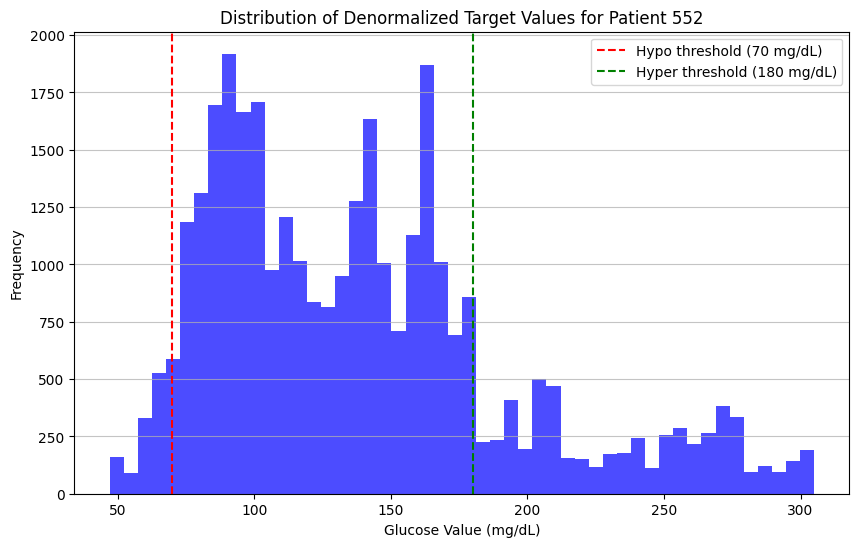

Patient 552:
Number of Hypo Target Values: 1200
Number of Hyper Target Values: 5715
Number of EU Target Values: 25797
Percentage of Hypo Target Values: 3.67%
Percentage of Hyper Target Values: 17.47%
Percentage of EU Target Values: 78.86%
--------------------------------------------------


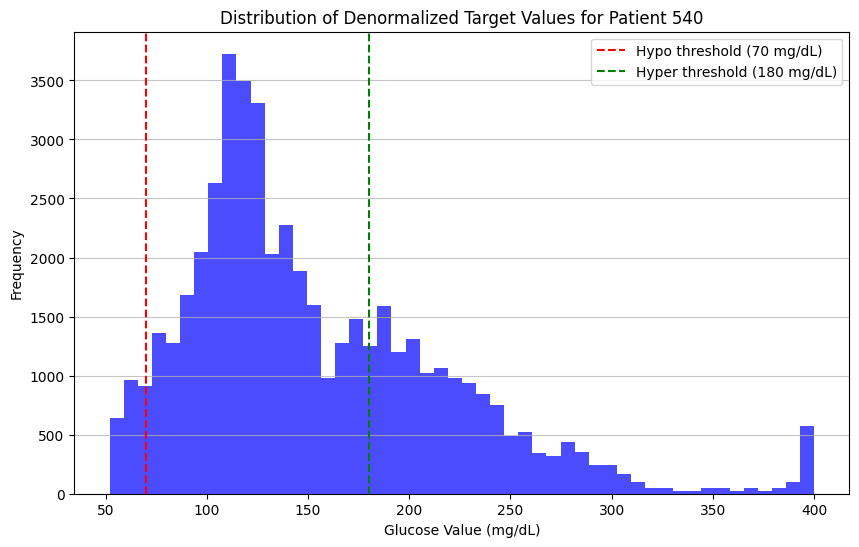

Patient 540:
Number of Hypo Target Values: 2132
Number of Hyper Target Values: 14803
Number of EU Target Values: 31857
Percentage of Hypo Target Values: 4.37%
Percentage of Hyper Target Values: 30.34%
Percentage of EU Target Values: 65.29%
--------------------------------------------------


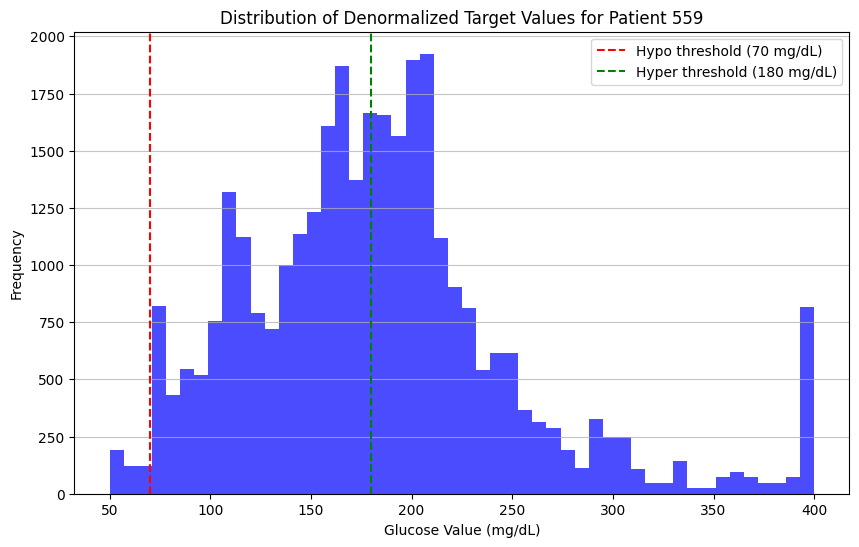

Patient 559:
Number of Hypo Target Values: 432
Number of Hyper Target Values: 15809
Number of EU Target Values: 16471
Percentage of Hypo Target Values: 1.32%
Percentage of Hyper Target Values: 48.33%
Percentage of EU Target Values: 50.35%
--------------------------------------------------


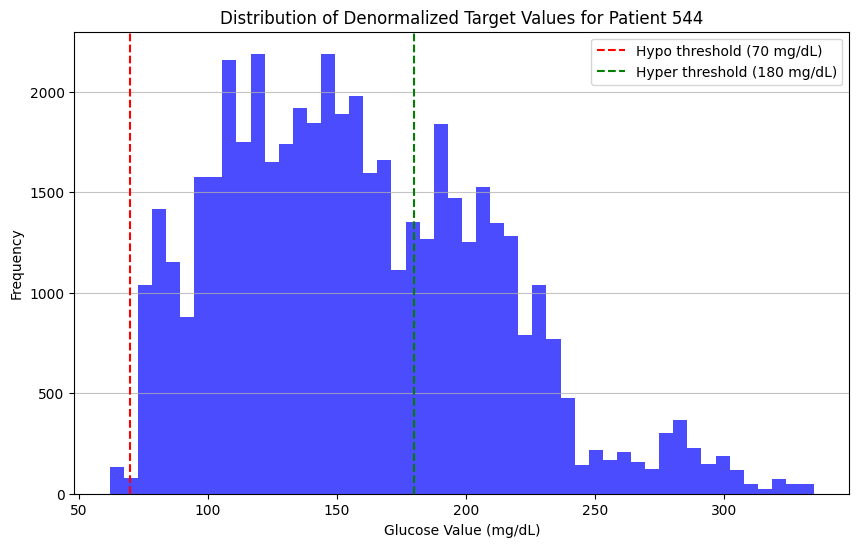

Patient 544:
Number of Hypo Target Values: 136
Number of Hyper Target Values: 16139
Number of EU Target Values: 32253
Percentage of Hypo Target Values: 0.28%
Percentage of Hyper Target Values: 33.26%
Percentage of EU Target Values: 66.46%
--------------------------------------------------


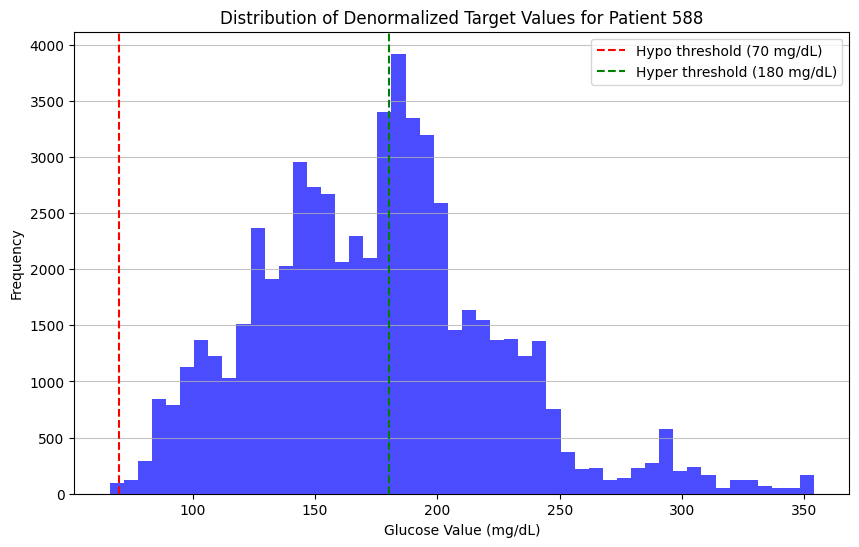

Patient 588:
Number of Hypo Target Values: 72
Number of Hyper Target Values: 27906
Number of EU Target Values: 32118
Percentage of Hypo Target Values: 0.12%
Percentage of Hyper Target Values: 46.44%
Percentage of EU Target Values: 53.44%
--------------------------------------------------


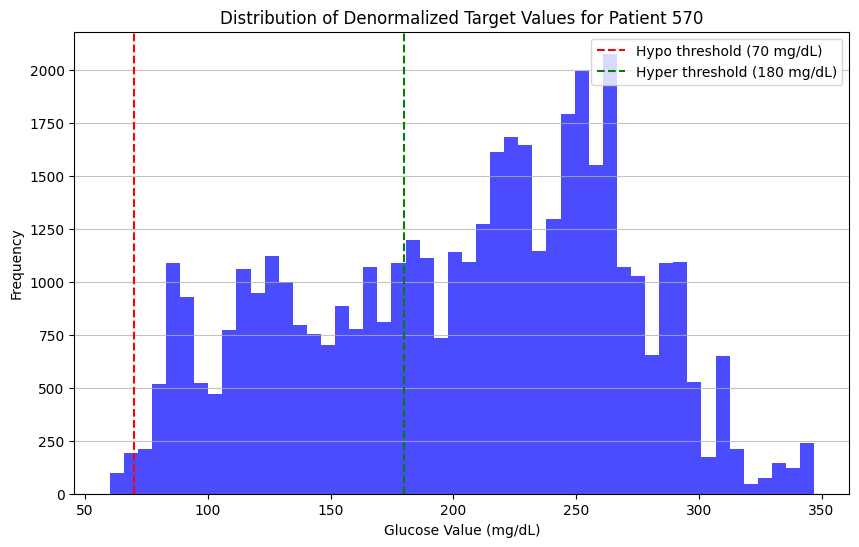

Patient 570:
Number of Hypo Target Values: 216
Number of Hyper Target Values: 28492
Number of EU Target Values: 15620
Percentage of Hypo Target Values: 0.49%
Percentage of Hyper Target Values: 64.28%
Percentage of EU Target Values: 35.24%
--------------------------------------------------


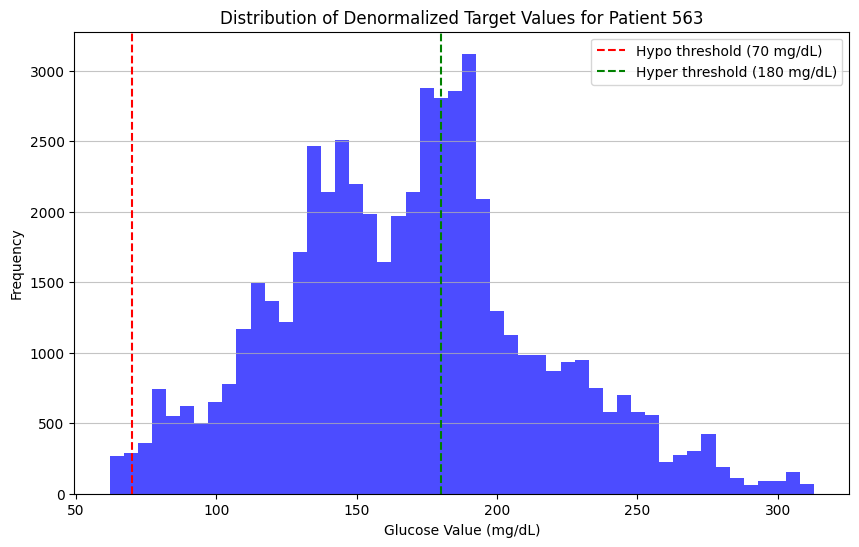

Patient 563:
Number of Hypo Target Values: 312
Number of Hyper Target Values: 21564
Number of EU Target Values: 32940
Percentage of Hypo Target Values: 0.57%
Percentage of Hyper Target Values: 39.34%
Percentage of EU Target Values: 60.09%
--------------------------------------------------


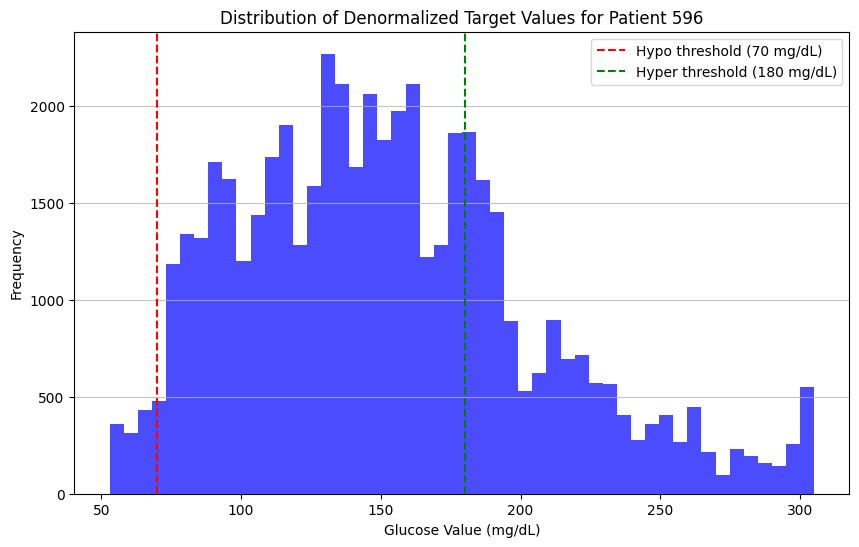

Patient 596:
Number of Hypo Target Values: 1152
Number of Hyper Target Values: 13779
Number of EU Target Values: 35757
Percentage of Hypo Target Values: 2.27%
Percentage of Hyper Target Values: 27.18%
Percentage of EU Target Values: 70.54%
--------------------------------------------------


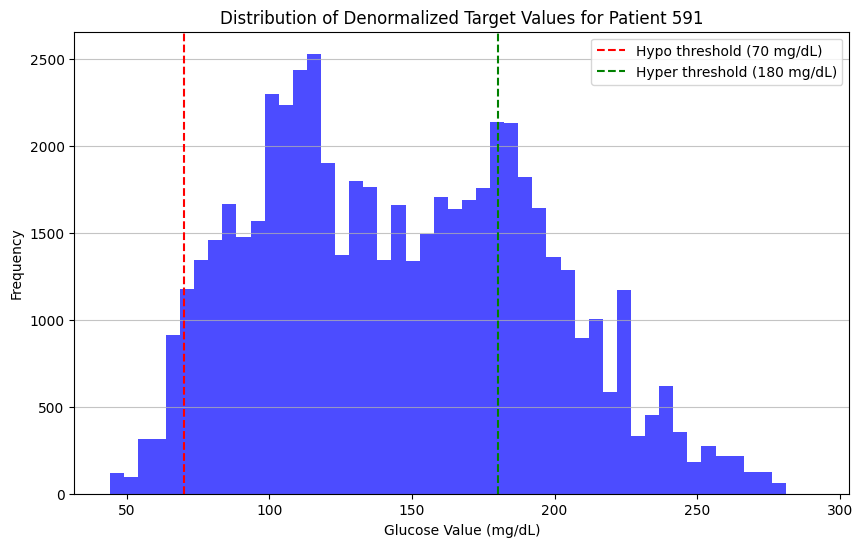

Patient 591:
Number of Hypo Target Values: 1926
Number of Hyper Target Values: 15723
Number of EU Target Values: 38727
Percentage of Hypo Target Values: 3.42%
Percentage of Hyper Target Values: 27.89%
Percentage of EU Target Values: 68.69%
--------------------------------------------------


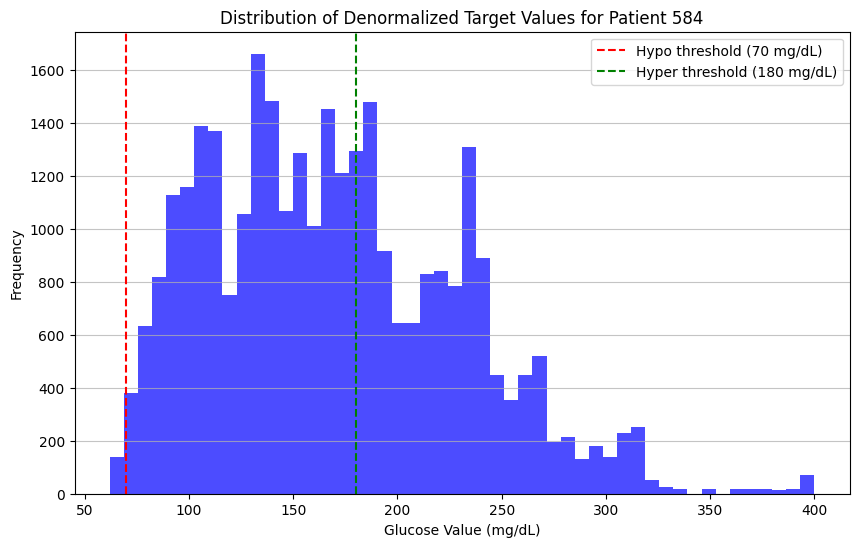

Patient 584:
Number of Hypo Target Values: 154
Number of Hyper Target Values: 12227
Number of EU Target Values: 18627
Percentage of Hypo Target Values: 0.50%
Percentage of Hyper Target Values: 39.43%
Percentage of EU Target Values: 60.07%
--------------------------------------------------


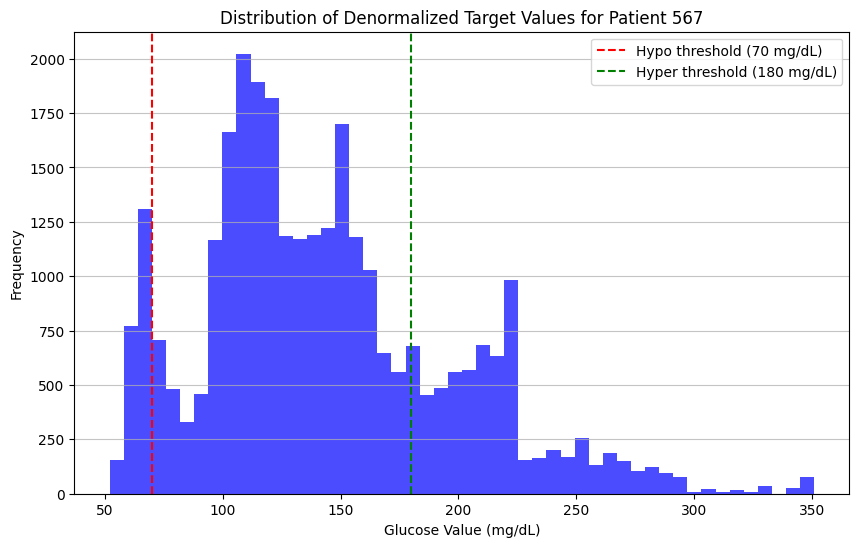

Patient 567:
Number of Hypo Target Values: 2234
Number of Hyper Target Values: 6840
Number of EU Target Values: 20638
Percentage of Hypo Target Values: 7.52%
Percentage of Hyper Target Values: 23.02%
Percentage of EU Target Values: 69.46%
--------------------------------------------------


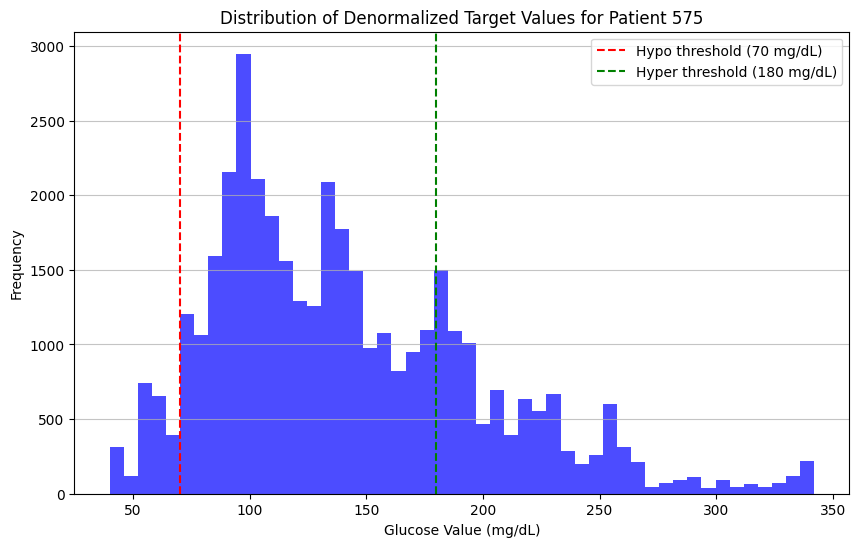

Patient 575:
Number of Hypo Target Values: 2143
Number of Hyper Target Values: 9444
Number of EU Target Values: 27845
Percentage of Hypo Target Values: 5.43%
Percentage of Hyper Target Values: 23.95%
Percentage of EU Target Values: 70.62%
--------------------------------------------------


In [ ]:
# read in all training target files for ptid 540, add all glucose values to a list, plot the distribution of the target values
ptid_list = [552, 540, 559, 544, 588, 570, 563, 596, 591, 584, 567, 575]

# Normalization parameters
normalisation_mean = 152.91051040286524
normalisation_std = 70.27050122812615

for i in ptid_list:
    target_dir = os.path.join(PROJECT_ROOT, "data", "processed_data", "ohio", "testing", f"ohio_test_{i}", "TargetSlices")

    target_files = os.listdir(target_dir)

    # Lists for normalized and denormalized values
    normalized_target_values = []
    denormalized_target_values = []

    for target_file in target_files:
        target_path = os.path.join(target_dir, target_file)
        target_tensor = torch.load(target_path)
        target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])
        
        # Store normalized values
        normalized_target_values.extend(target_df['GlucoseValue'].tolist())
        
        # Denormalize the values
        denormalized_df = target_df.copy()
        denormalized_df['GlucoseValue'] = (denormalized_df['GlucoseValue'] * normalisation_std) + normalisation_mean
        denormalized_target_values.extend(denormalized_df['GlucoseValue'].tolist())

    # Plot denormalized values
    plt.figure(figsize=(10, 6))
    plt.hist(denormalized_target_values, bins=50, alpha=0.7, color='blue')
    plt.title(f"Distribution of Denormalized Target Values for Patient {i}")
    plt.xlabel('Glucose Value (mg/dL)')
    plt.ylabel('Frequency')
    plt.axvline(x=70, color='r', linestyle='--', label='Hypo threshold (70 mg/dL)')
    plt.axvline(x=180, color='g', linestyle='--', label='Hyper threshold (180 mg/dL)')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()
    plt.show()

    # Count using denormalized values
    hypo_target_values = [value for value in denormalized_target_values if value < 70]
    hyper_target_values = [value for value in denormalized_target_values if value > 180]
    eu_target_values = [value for value in denormalized_target_values if 70 <= value <= 180]

    print(f"Patient {i}:")
    print(f"Number of Hypo Target Values: {len(hypo_target_values)}")
    print(f"Number of Hyper Target Values: {len(hyper_target_values)}")
    print(f"Number of EU Target Values: {len(eu_target_values)}")

    percent_hypo = len(hypo_target_values) / len(denormalized_target_values) * 100
    percent_hyper = len(hyper_target_values) / len(denormalized_target_values) * 100
    percent_eu = len(eu_target_values) / len(denormalized_target_values) * 100
    
    print(f"Percentage of Hypo Target Values: {percent_hypo:.2f}%")
    print(f"Percentage of Hyper Target Values: {percent_hyper:.2f}%")
    print(f"Percentage of EU Target Values: {percent_eu:.2f}%")
    print("-" * 50)

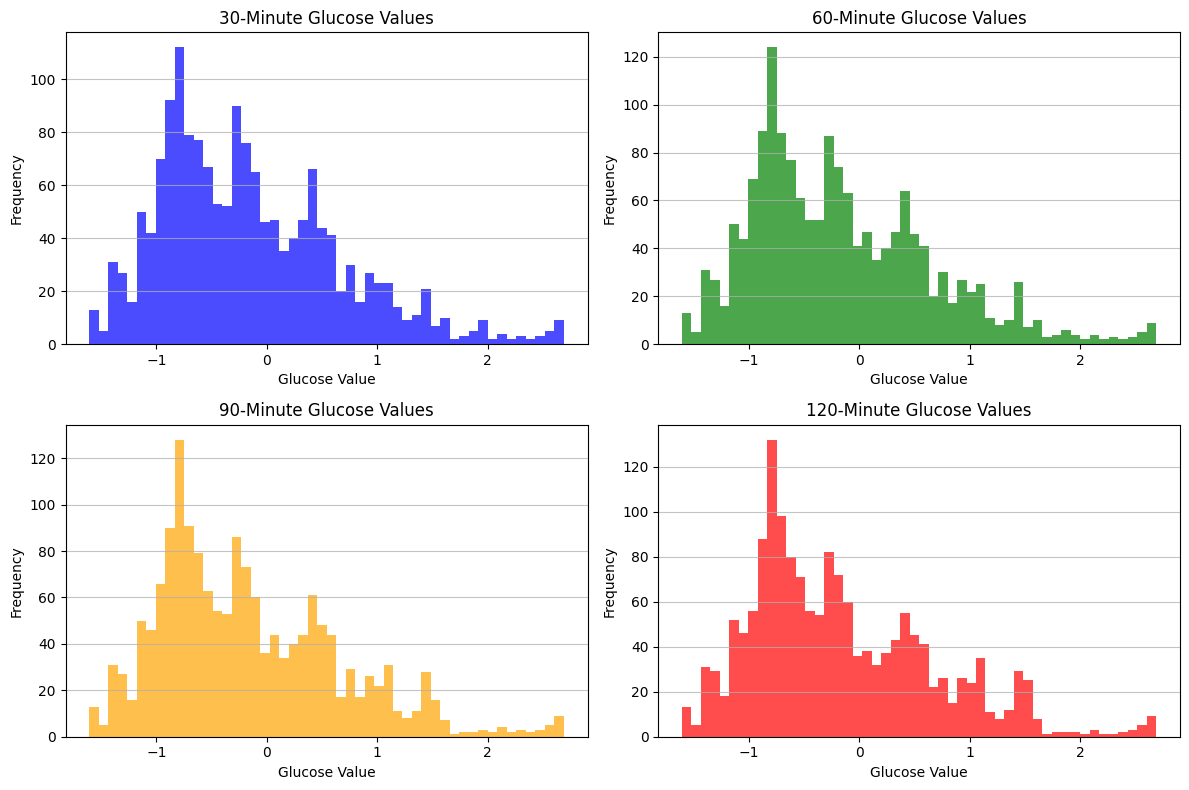

In [ ]:
# Initialize lists for different time intervals
glucose_30min = []
glucose_60min = []
glucose_90min = []
glucose_120min = []

# Iterate through all target files and extract the required glucose values
for target_file in target_files:
    target_path = os.path.join(target_dir, target_file)
    target_tensor = torch.load(target_path)
    target_df = pd.DataFrame(target_tensor.numpy(), columns=["GlucoseValue"])
    
    # Add the 5th, 11th, 17th, and 23rd glucose values to respective lists
    glucose_30min.append(target_df.iloc[5]['GlucoseValue'])
    glucose_60min.append(target_df.iloc[11]['GlucoseValue'])
    glucose_90min.append(target_df.iloc[17]['GlucoseValue'])
    glucose_120min.append(target_df.iloc[23]['GlucoseValue'])

# Plot each list
plt.figure(figsize=(12, 8))

# Plot for 30-minute glucose values
plt.subplot(2, 2, 1)
plt.hist(glucose_30min, bins=50, alpha=0.7, color='blue')
plt.title('30-Minute Glucose Values')
plt.xlabel('Glucose Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plot for 60-minute glucose values
plt.subplot(2, 2, 2)
plt.hist(glucose_60min, bins=50, alpha=0.7, color='green')
plt.title('60-Minute Glucose Values')
plt.xlabel('Glucose Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plot for 90-minute glucose values
plt.subplot(2, 2, 3)
plt.hist(glucose_90min, bins=50, alpha=0.7, color='orange')
plt.title('90-Minute Glucose Values')
plt.xlabel('Glucose Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plot for 120-minute glucose values
plt.subplot(2, 2, 4)
plt.hist(glucose_120min, bins=50, alpha=0.7, color='red')
plt.title('120-Minute Glucose Values')
plt.xlabel('Glucose Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()
